# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
# добавим все библиотеки, которые будут использоваться
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
display(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [5]:
display(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Из условия знаем, что:
**id** — уникальный идентификатор скважины

**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы)

**product** — объём запасов в скважине (тыс. баррелей).

In [6]:
dataframes = [data_0, data_1, data_2]

In [7]:
for data in dataframes:
    print(data.describe())
    print()

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%      

Видно, что признаки f0, f1, f2 не имеют действительно больших отличий друг от друга, чтобы имело место применение масштабирования. Фактически во всех датафреймах они разбросаны +- в одном-двух десятках вокруг нуля и не имеют разницы в несколько порядков

In [8]:
for data in dataframes:
    print(data.isna().sum())
    print()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



In [9]:
for data in dataframes:
    print(data.duplicated().sum())
    print()

0

0

0



В данных нет пропусков и дубликатов, следовательно с ними можно работать дальше

В рамках исследований нам не понадобятся знания об id скважин, поэтому для разгрузки памяти предлагаю их удалить

In [10]:
for data in dataframes:
    del data['id']

Посмотрим по графикам для приблизительной оценки выбора наиболее перспективного региона как распределены признаки и целевой признак в исследуемых датафреймах

In [11]:
columns = data_1.columns

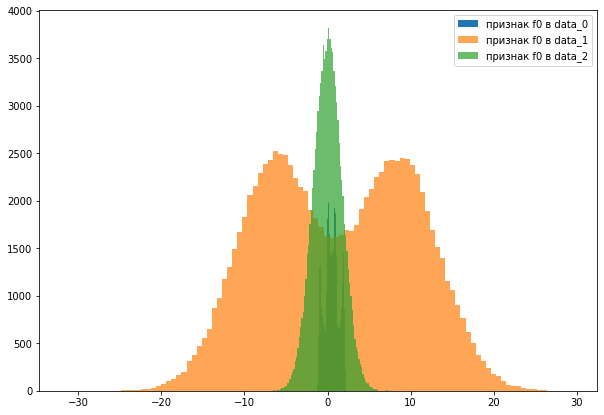

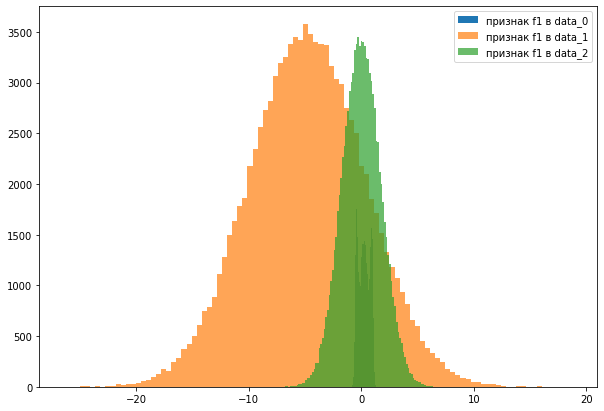

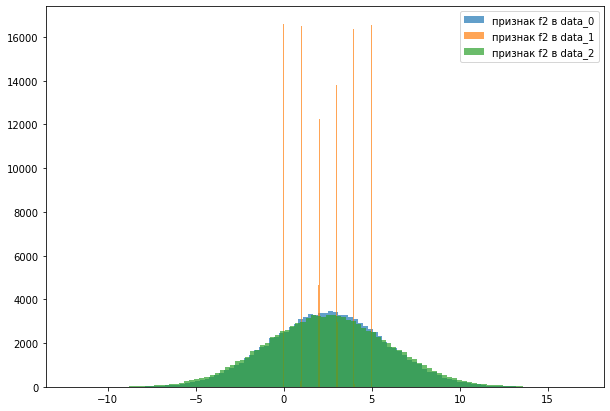

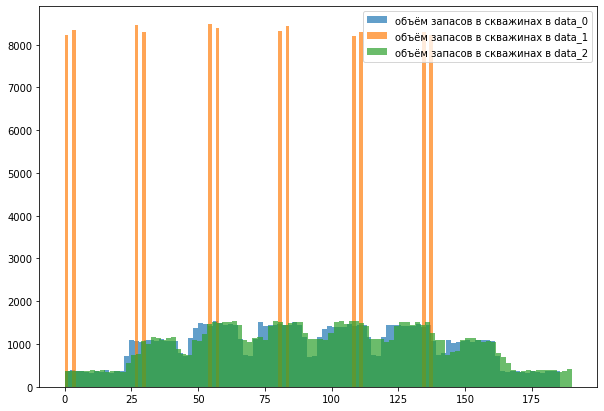

In [12]:
for column in columns:
    if column == 'f0':
        plt.figure(figsize=(10,7))
        plt.hist(data_0[column], bins=100, label='признак f0 в data_0')
        plt.hist(data_1[column], bins=100, label='признак f0 в data_1', alpha=0.7)
        plt.hist(data_2[column], bins=100, label='признак f0 в data_2', alpha=0.7)
        plt.legend(loc='upper right')
        plt.show()
    elif column == 'f1':
        plt.figure(figsize=(10,7))
        plt.hist(data_0[column], bins=100, label='признак f1 в data_0')
        plt.hist(data_1[column], bins=100, label='признак f1 в data_1', alpha=0.7)
        plt.hist(data_2[column], bins=100, label='признак f1 в data_2', alpha=0.7)
        plt.legend(loc='upper right')
        plt.show()
    elif column == 'f2':
        plt.figure(figsize=(10,7))
        plt.hist(data_0[column], bins=100, label='признак f2 в data_0', alpha=0.7)
        plt.hist(data_1[column], bins=100, label='признак f2 в data_1', alpha=0.7)
        plt.hist(data_2[column], bins=100, label='признак f2 в data_2', alpha=0.7)
        plt.legend(loc='upper right')
        plt.show()
    elif column == 'product':
        plt.figure(figsize=(10,7))
        plt.hist(data_0[column], bins=100, label='объём запасов в скважинах в data_0', alpha=0.7)
        plt.hist(data_1[column], bins=100, label='объём запасов в скважинах в data_1', alpha=0.7)
        plt.hist(data_2[column], bins=100, label='объём запасов в скважинах в data_2', alpha=0.7)
        plt.legend(loc='upper right')
        plt.show()

In [13]:
len(data_1['product'].unique())

12

Как видно, почти все данные распределны нормально. Исключение составляет датафрейм data_1, который явно имеет очень мало уникальных значений - по сути глядя на гистограммы, и перепроверив это вручную, убеждаемся, что там фактически 12 уникальных скважин по объёму запасов, но с разными id - и признаками f1, f2, f3. Вероятно когда модель будет учиться по этому датафрейму, она удивится

## Обучение и проверка модели

По условию используем только линейную регрессию для обучения

In [14]:
model_0 = LinearRegression()
model_1 = LinearRegression()
model_2 = LinearRegression()

In [15]:
features_0 = data_0.drop(['product'], axis=1)
target_0 = data_0['product']
features_1 = data_1.drop(['product'], axis=1)
target_1 = data_1['product']
features_2 = data_2.drop(['product'], axis=1)
target_2 = data_2['product']

In [16]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [17]:
model_0.fit(features_train_0, target_train_0)
model_1.fit(features_train_1, target_train_1)
model_2.fit(features_train_2, target_train_2);

In [18]:
predictions_0 = model_0.predict(features_valid_0)
predictions_1 = model_1.predict(features_valid_1)
predictions_2 = model_2.predict(features_valid_2)

In [19]:
rmse_0 = mean_squared_error(target_valid_0, predictions_0)**0.5
rmse_1 = mean_squared_error(target_valid_1, predictions_1)**0.5
rmse_2 = mean_squared_error(target_valid_2, predictions_2)**0.5

In [20]:
rmse = [rmse_0, rmse_1, rmse_2]
average_product = [predictions_0.mean(), predictions_1.mean(), predictions_2.mean()]
labels = ['data_0', 'data_1', 'data_2']

for index in range(len(rmse)):
    print(f'Для датафрейма {labels[index]} значение RMSE = {rmse[index]} и средний запас предсказанного сырья {average_product[index]} тыс. баррелей')

Для датафрейма data_0 значение RMSE = 37.5794217150813 и средний запас предсказанного сырья 92.59256778438038 тыс. баррелей
Для датафрейма data_1 значение RMSE = 0.893099286775616 и средний запас предсказанного сырья 68.728546895446 тыс. баррелей
Для датафрейма data_2 значение RMSE = 40.02970873393434 и средний запас предсказанного сырья 94.96504596800489 тыс. баррелей


Можем сказать, что для data_1 самые точные предсказания (RMSE очень близка к 0), но средний запас предсказанного сырья весьма мал. Если же говорить о data_0 и data_2, то тут ситуация обратная - RMSE весьма большой по сравнению с RMSE data_1, но зато средний запас сырья весьма высокий (хоть получается это и не такая точная информация, как предсказания для data_1).

Можно сравнить предсказанные средние объёмы скважин с реальным средним чтобы понять насколько сильно ошиблись данные модели

In [21]:
real_average_product = [target_valid_0.mean(), target_valid_1.mean(), target_valid_2.mean()]

In [22]:
for index in range(len(real_average_product)):
    print(f'Для скважин в {labels[index]} реальное среднее значение запасов {real_average_product[index]}')

Для скважин в data_0 реальное среднее значение запасов 92.07859674082927
Для скважин в data_1 реальное среднее значение запасов 68.72313602435997
Для скважин в data_2 реальное среднее значение запасов 94.88423280885438


Как видно, погрешность по факту не так велика - меньше 1 процента. То есть пока что можем сказать, что регион с самыми перспективными месторождениями нефти это банально выбранный регион по среднему значению объёмов залежей в нём - то есть регион с данными из data_2

## Подготовка к расчёту прибыли

In [23]:
searching_area = 500                   # при исследовании выбирают 500 точек в регионе
choice_area = 200                      # 200 самых "богатых" точек в итоге выбирают для выкачивания нефти
budget = 10**10                        # бюджет 10 млрд
product_profit = 450000                # доход с одной проданной тысячи баррелей
success_chance = 97.5                  # требуемый уровень вероятности того, что проект не пойдет в убыток

как я понимаю, для дальнейших действий необходимо в каждый из датафреймов помимо реальных запасов нефти добавить столбец с предсказываемым моделью запасом нефти, на который мы и будем ориентироваться при выборе самых "богатых" мест для скважин

In [24]:
data_0['predicted'] = pd.Series(model_0.predict(features_0))
data_1['predicted'] = pd.Series(model_1.predict(features_1))
data_2['predicted'] = pd.Series(model_2.predict(features_2))

так как мы ориентируемся именно на то, что нам предсказывает модель, то отсортируем по убыванию датафреймы по столбцу "predicted" и далее отрежем первые 200 из них - ведь именно столько точек выбирают для выкачивания нефти

In [25]:
data_0_best_sources = data_0.sort_values(by='predicted', ascending=False)[:choice_area]
data_1_best_sources = data_1.sort_values(by='predicted', ascending=False)[:choice_area]
data_2_best_sources = data_2.sort_values(by='predicted', ascending=False)[:choice_area]

теперь мы выбрали 200 самых "богатых" по мнению моделей скважин в каждом регионе. проверим потянут ли они окупаемость бюджета, который будет потрачен на разработку скважин в выбранном регионе

In [26]:
needed_barrels = budget/product_profit
print(f'Миниально в регионе нужно захоронений на {needed_barrels} тыс. баррелей')

Миниально в регионе нужно захоронений на 22222.222222222223 тыс. баррелей


вот столько тысяч баррелей должно быть в регионе, чтобы он окупил выделенный бюджет. проверим какой суммарный запас объёмов на самом деле в лучших 200 скважинах по мнению моделей

In [27]:
best_sources = [data_0_best_sources, data_1_best_sources, data_2_best_sources]
for index in range(len(labels)):
    print(f'В лучших 200 скважинах датафрейма {labels[index]} находится {best_sources[index]["product"].sum()} тыс. баррелей')

В лучших 200 скважинах датафрейма data_0 находится 29986.898204693367 тыс. баррелей
В лучших 200 скважинах датафрейма data_1 находится 27589.081548181137 тыс. баррелей
В лучших 200 скважинах датафрейма data_2 находится 27936.468071024286 тыс. баррелей


Как видно, модель в каждом из регионов предсказала 200 таких скважин, что они будут прибыльными для выбора - объемов нефти там больше, чем требуется для минимальной окупаемости. Посчитаем в каждом из регионов прибыль чтобы перейти от баррелей к деньгам для наглядности

In [28]:
average_needed_barrels = budget/(product_profit*choice_area)
print(f'Средний запас в одной скважине для безубыточности проекта должен быть {average_needed_barrels:.3f} тыс. баррелей')

Средний запас в одной скважине для безубыточности проекта должен быть 111.111 тыс. баррелей


In [29]:
for index in range(len(labels)):
    print(f'В лучших 200 скважинах датафрейма {labels[index]} находится в среднем {best_sources[index]["product"].mean():.3f} тыс. баррелей')

В лучших 200 скважинах датафрейма data_0 находится в среднем 149.934 тыс. баррелей
В лучших 200 скважинах датафрейма data_1 находится в среднем 137.945 тыс. баррелей
В лучших 200 скважинах датафрейма data_2 находится в среднем 139.682 тыс. баррелей


Как и ожидалось, средний запас объёмов в 200 лучших скважинах больше минимального 111 тыс. баррель , что и даёт далее положительную прибыль, если выбирать топ-200 из всего датафрейма. Осложняется ситуация когда мы работаем со случайнми 500 скважинами - так как вычисленные ранее средние запасы нефти по всему датафрейму во всех регионах до этого самого минимума не дотягивают. Этим собственно и обусловлено желание заказчика оценить риски при случайном выборе 500 скважин для последующего анализа

## Расчёт прибыли и рисков 

In [30]:
profitable_size = []
for data in best_sources:
    profitable_size.append(data["product"].sum()-needed_barrels)

In [31]:
profitable_size

[7764.675982471144, 5366.859325958914, 5714.245848802064]

Теперь известно насколько превышает реальный объём требуемый. Посчитаем прибыль от этой разницы

In [32]:
for index in range(len(profitable_size)):
    print(f'Для датафрейма {labels[index]} реальная выручка составит {(profitable_size[index]*product_profit)/10**9} млрд. рублей')

Для датафрейма data_0 реальная выручка составит 3.494104192112015 млрд. рублей
Для датафрейма data_1 реальная выручка составит 2.415086696681511 млрд. рублей
Для датафрейма data_2 реальная выручка составит 2.571410631960929 млрд. рублей


Получилось, что если полагаться именно на советы обученной модели, то самое перспективное по прибыли - это регион из датафрейма data_0 - там почти на целый миллиард больше прибыль, чем в регионах с датафреймами data_1 и data_2. По крайней мере это если полагаться при выборе скважин на мнение моделей

Теперь выполним оценку рисков: известно, что из общего датафрейма для исследования берут 500 скважин, где опираясь на мнение моделей для добычи нефти окончательно выбирают 200 лучших. Сделаем 1000 таких выборок и посмотрим с какими рисками в каждом из регионов можно уйти в минус. Нужно чтобы вероятность успеха была больше 97.5 %

In [33]:
state = np.random.RandomState(12345)

In [34]:
for data in dataframes:
    print(data.shape[0])

100000
100000
100000


В каждом датафрейме 100 000 данных по скважинам, но при разведке берут лишь 500 из них, следовательно рассматриваемая доля скважин из каждого датафрейма:

In [35]:
research_part = searching_area/data_0.shape[0]
print(research_part)

0.005


In [36]:
def risk_calc(data, research_part=research_part, choice_area=choice_area, state=state, product_profit=product_profit):
    profit = []
    for i in range(1000):
        research_sample = data.sample(frac=research_part, random_state=state, replace=True)
        best_sources = research_sample.sort_values(by='predicted', ascending=False)[:choice_area]
        product_value = best_sources['product'].sum()
        profit.append((product_value*product_profit)/10**9)
    return pd.Series(profit).quantile(0.025)   

In [37]:
for index in range(len(dataframes)):
    print(f'В датафрейме {labels[index]} 97,5 % шанс, что прибыль будет выше,чем {risk_calc(dataframes[index])} млрд. рублей')

В датафрейме data_0 97,5 % шанс, что прибыль будет выше,чем 9.922143076265112 млрд. рублей
В датафрейме data_1 97,5 % шанс, что прибыль будет выше,чем 10.04241963633193 млрд. рублей
В датафрейме data_2 97,5 % шанс, что прибыль будет выше,чем 9.853298451855853 млрд. рублей


Как видно, требование о том, чтобы риск уйти в минус был не больше 2.5 % при случайном выборе 500 скважин в регионе и отборе из них 200 лучших по предсказаниям модели - соблюдается только в регионе, относящемся к data_1 (прибыль больше 10 млрд. вкладываемого бюждета). В остальных регионах шанс уйти в минус уже больше.
Если резюмировать: в data_1 всего 12 уникальных значений запасов нефти - что довольно нереалистично, но тем не менее - это делает данный регион самым стабильным - в нём возможно нет суперприбыльных скважин, но из-за малого разброса данных по запасам модель гораздо лучше обучилась в данном регионе (гораздо более низкий RMSE) , и следовательно, гораздо лучше предсказывала самые прибыльные месторождения. Запасы нефти в data_0 и data_2 же имели очень большой разброс, и, соответственно, модели с большим RMSE там были хуже обучены, и судя по всему даже при большем денежном потенциале (как показал предварительный обсчёт - самые "богатые" 200 захоронений в этих датафреймах дают больше прибыли, чем в data_1) выбирать случайные 500 месторождений и доверять выбор оставшихся 200 моделям - дело опасное, и риски прогореть там уже выше 2.5 %. Поэтому конкретно из 3-х данных регионов для соблюдения требуемой вероятности успеха стоит выбрать именно регион с data_1

In [38]:
def profit_calc(data, research_part=research_part, choice_area=choice_area, state=state, product_profit=product_profit):
    profit = []
    for i in range(1000):
        research_sample = data.sample(frac=research_part, random_state=state, replace=True)
        best_sources = research_sample.sort_values(by='predicted', ascending=False)[:choice_area]
        product_value = best_sources['product'].sum()
        budget_accounting = ((product_value*product_profit)/10**9) - 10 # вычитаем 10 млрд. бюджета
        profit.append(budget_accounting)
    return pd.Series(profit)

In [39]:
for index in range(len(dataframes)):
    print(f'В датафрейме {labels[index]} средняя прибыль {(profit_calc(dataframes[index]).mean()):.3f} млрд. рублей')
    print(f'В датафрейме {labels[index]} 95 % доверительный интервал от {(profit_calc(dataframes[index]).quantile(0.025)):.3f} млрд. рублей до {(profit_calc(dataframes[index]).quantile(0.975)):.3f} млрд. рублей')
    print(f'В датафрейме {labels[index]} риск уйти в убыток {((profit_calc(dataframes[index]) < 0).mean() * 100):.3f} %')

В датафрейме data_0 средняя прибыль 0.417 млрд. рублей
В датафрейме data_0 95 % доверительный интервал от -0.104 млрд. рублей до 0.955 млрд. рублей
В датафрейме data_0 риск уйти в убыток 4.500 %
В датафрейме data_1 средняя прибыль 0.454 млрд. рублей
В датафрейме data_1 95 % доверительный интервал от 0.045 млрд. рублей до 0.864 млрд. рублей
В датафрейме data_1 риск уйти в убыток 1.400 %
В датафрейме data_2 средняя прибыль 0.364 млрд. рублей
В датафрейме data_2 95 % доверительный интервал от -0.182 млрд. рублей до 0.872 млрд. рублей
В датафрейме data_2 риск уйти в убыток 9.700 %


Данный дополнительный пересчёт, где была вычислена чистая прибыль с учётом потерь средств на сам по себе бюждет проекта - по сути продублировало выше записанный вывод и ещё раз его закрепило - распределение друг относительно друга по суммарной прибыли и рискам уйти в убыток по регионам отсалось то же.